In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV




In [21]:
df = pd.read_csv('Body.csv')
df.head()

,Gender,Age,HeadCircumference,ShoulderWidth,ChestWidth,Belly,Waist,Hips,ArmLength,ShoulderToWaist,WaistToKnee,LegLength,TotalHeight
0,1,30,22,18,20,18,14,22,22,25,25,22,52
1,1,28,19,22,17,18,21,25,28,23,25,20,56
2,2,27,21,18,16,14,10,15,21,18,14,18,53
3,1,29,20,20,18,11,19,14,24,21,20,21,45
4,2,28,16,14,18,13,11,30,25,22,32,13,47


In [22]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(156)

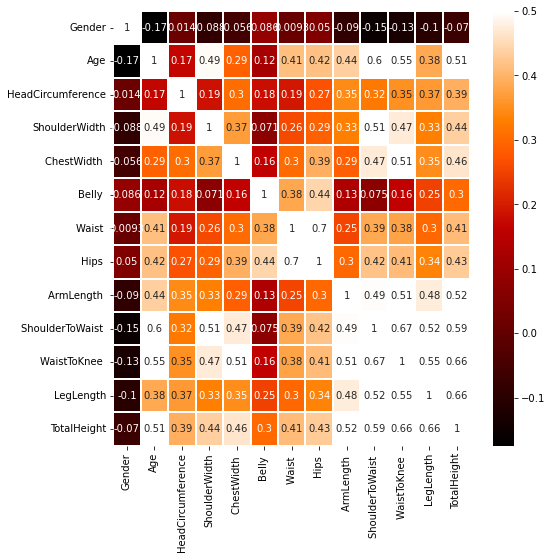

In [23]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), linewidths=0.1, vmax=0.5, cmap=plt.cm.gist_heat, linecolor='white', annot=True)
plt.show()

In [24]:
dataset = df.values
X=dataset[:,0:12]
Y=dataset[:,12]

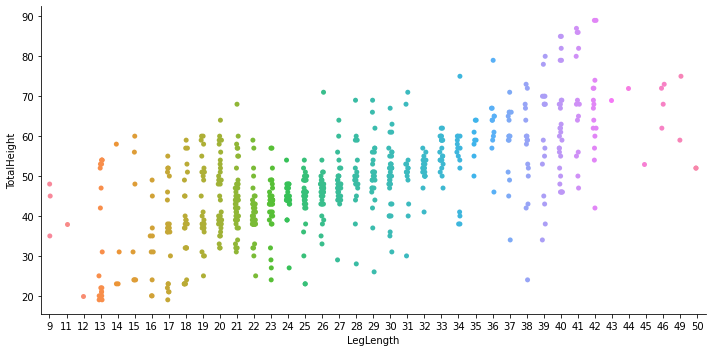

In [25]:
sns.catplot(data=df, x='LegLength', y='TotalHeight', aspect=2)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [27]:
# 변형 객체 생성
minmax_scaler = MinMaxScaler()

# 훈련데이터의 모수 분포 저장
minmax_scaler.fit(X_train)

# 훈련 데이터 스케일링
X_train = minmax_scaler.transform(X_train)

# 테스트 데이터의 스케일링
X_test = minmax_scaler.transform(X_test)

In [28]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(501, 12) (215, 12) (501,) (215,)


In [35]:
from sklearn.model_selection import cross_val_score
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [36]:
# Train model
lr = LinearRegression().fit(X_train, y_train)
# get cross val scores
get_cv_scores(lr)

CV Mean:  0.5041443114834736
STD:  0.17321489337964324




In [48]:
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print("가중치(계수, 기울기 파라미터 W) :", lr.coef_)
print("편향(절편 파라미터 b) :", lr.intercept_)
print('MSE : {}, RMSE : {}'.format(mse, rmse))
print('Variance score : {}'.format(r2_score(y_test, y_preds)))
print("훈련세트 점수: {:.2f}".format( lr.score(X_train, y_train) ))
print("테스트세트 점수: {:.2f}".format( lr.score(X_test, y_test) ))

lr.score(X_test, y_test)

가중치(계수, 기울기 파라미터 W) : [ 0.33565143  6.95081195 13.95005854  7.72300329  8.58677484 25.60575066
 10.73249157 -3.54121661 11.13230512  6.76287623 14.87425838 18.35152444]

편향(절편 파라미터 b) : 14.494424395693933
MSE : 69.76839055040779, RMSE : 8.352747485133726

Variance score : 0.5551518845037439

훈련세트 점수: 0.64

테스트세트 점수: 0.56


0.5551518845037439

In [38]:

# Train model with default alpha=1
ridge = Ridge(alpha=1).fit(X_train, y_train)
# get cross val scores
get_cv_scores(ridge)

CV Mean:  0.5997799716201817
STD:  0.06519098588144612




In [49]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag' 'saga']
max_iter = [100, 1000, 10000, 100000]

param_grid = dict(alpha=alpha, solver=solver, max_iter=max_iter)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', 
                    verbose=1, n_jobs=-1, return_train_score=True)
grid = grid.fit(X_train, y_train)
print('GridSearchCV 최적 파라미터:', grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

par = grid.best_params_
score = grid.best_score_

best_mod = Ridge(alpha = par['alpha'], max_iter=par['max_iter'], solver=par['solver'])
best_mod.fit(X_train, y_train)
pred = best_mod.predict(X_test)



Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s


GridSearchCV 최적 파라미터: {'alpha': 1, 'max_iter': 100, 'solver': 'sparse_cg'}
GridSearchCV 최고 정확도: 0.5999


[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:    5.4s finished


In [50]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print("가중치(계수, 기울기 파라미터 W) :", best_mod.coef_)
print("편향(절편 파라미터 b) :", best_mod.intercept_)

print('MSE : {}, RMSE : {}'.format(mse, rmse))
print('Variance score : {}'.format(r2_score(y_test, pred)))

print("훈련세트 점수: {:.2f}".format( best_mod.score(X_train, y_train) ))
print("테스트세트 점수: {:.2f}".format( best_mod.score(X_test, y_test) ))

best_mod.score(X_test, y_test)


가중치(계수, 기울기 파라미터 W) : [ 0.37265692  7.03426294 12.66634078  5.08630464  8.84234296 14.06968855
  8.76558364 -0.20931405  9.65631874  7.03858573 13.63896988 18.61793941]
편향(절편 파라미터 b) : 16.46237744231499
MSE : 69.09680379938204, RMSE : 8.312448724616715
Variance score : 0.5594339683848419
훈련세트 점수: 0.64
테스트세트 점수: 0.56


0.5594339683848419

In [40]:
# Train model with default alpha=1
lasso = Lasso(alpha=1).fit(X_train, y_train)

# get cross val scores
get_cv_scores(lasso)

CV Mean:  0.22806116671763726
STD:  0.02131105080974909




In [58]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
max_iter = [100, 1000, 10000, 100000]
param_grid = dict(alpha=alpha, max_iter=max_iter)

grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', 
                    verbose=1, n_jobs=-1, return_train_score=True)
grid = grid.fit(X_train, y_train)

print('GridSearchCV 최적 파라미터:', grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

par = grid.best_params_
score = grid.best_score_

best_mod = Lasso(alpha = par['alpha'])
best_mod.fit(X_train, y_train)
pred = best_mod.predict(X_test)



Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GridSearchCV 최적 파라미터: {'alpha': 0.1, 'max_iter': 100}
GridSearchCV 최고 정확도: 0.5781


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.2s finished


In [59]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print('MSE : {}, RMSE : {}'.format(mse, rmse))
print('Variance score : {}'.format(r2_score(y_test, pred)))

print("가중치(계수, 기울기 파라미터 W) :", best_mod.coef_)
print("편향(절편 파라미터 b) :", best_mod.intercept_)

print("훈련세트 점수: {:.2f}".format( best_mod.score(X_train, y_train) ))
print("테스트세트 점수: {:.2f}".format( best_mod.score(X_test, y_test) ))

best_mod.score(X_test, y_test)

MSE : 68.98261073051037, RMSE : 8.305577085941131
Variance score : 0.5601620713422062
가중치(계수, 기울기 파라미터 W) : [ 0.08998212  6.88618153  9.88997285  0.          9.03160252  0.
  3.55382779  1.5890107   1.81614887  6.57867077 13.75829426 20.9364362 ]
편향(절편 파라미터 b) : 21.23007330926387
훈련세트 점수: 0.62
테스트세트 점수: 0.56


0.5601620713422062

In [60]:
# Train model with default alpha=1 and l1_ratio=0.5
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_train, y_train)
# get cross val scores
get_cv_scores(elastic_net)

CV Mean:  0.08533823683361341
STD:  0.016279798129382118




In [61]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)

grid = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='r2', 
                    verbose=1, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

print('GridSearchCV 최적 파라미터:', grid.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

par = grid.best_params_
score = grid.best_score_

best_mod = ElasticNet(alpha = par['alpha'], max_iter=100000, l1_ratio = par['l1_ratio'])
best_mod.fit(X_train, y_train)
pred = best_mod.predict(X_test)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


GridSearchCV 최적 파라미터: {'alpha': 0.01, 'l1_ratio': 0.5}
GridSearchCV 최고 정확도: 0.6012


[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.6s finished


In [63]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print('MSE : {}, RMSE : {}'.format(mse, rmse))
print('Variance score : {}'.format(r2_score(y_test, pred)))
print("가중치(계수, 기울기 파라미터 W) :", best_mod.coef_)
print("편향(절편 파라미터 b) :", best_mod.intercept_)
print("훈련세트 점수: {:.2f}".format( best_mod.score(X_train, y_train) ))
print("테스트세트 점수: {:.2f}".format( best_mod.score(X_test, y_test) ))

best_mod.score(X_test, y_test)

MSE : 68.78135104897794, RMSE : 8.29345229979518

Variance score : 0.5614453170835623

가중치(계수, 기울기 파라미터 W) : [ 0.34516469  7.07337672 11.21439586  3.28147176  8.93015165  8.19941674
  6.73755954  1.92146708  8.16623331  7.63544818 12.36290011 18.15872847]

편향(절편 파라미터 b) : 18.59897593965231

훈련세트 점수: 0.63

테스트세트 점수: 0.56


0.5614453170835623